In [20]:
import json
import logging
import sys
import os
import numpy as np
import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision.models import vgg16


def get_modified_vgg16_unet(in_channels=3):
    """ Get a modified VGG16-Unet model with customized input channel numbers.
    For example, we can set in_channels=3 and input RGB 3-channel images.
    On the other hand, we can set in_channels=5 if we want to input both RGB
    and 2-channel LIDAR data (elevation + intensity).
    """
    class Modified_VGG16Unet(VGG16Unet):
        def __init__(self):
            super().__init__(in_channels=in_channels)
    return Modified_VGG16Unet


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvRelu(in_channels, middle_channels),
            ConvRelu(middle_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = nn.Conv2d(in_, out, 3, padding=1)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class VGG16Unet(nn.Module):
    def __init__(self, in_channels=3, num_filters=32, pretrained=False):
        super().__init__()
        # Get VGG16 net as encoder
        self.encoder = vgg16(pretrained=pretrained).features
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

        # Modify encoder architecture
        self.encoder[0] = nn.Conv2d(
            in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Sequential(
            self.encoder[0], self.relu, self.encoder[2], self.relu)
        self.conv2 = nn.Sequential(
            self.encoder[5], self.relu, self.encoder[7], self.relu)
        self.conv3 = nn.Sequential(
            self.encoder[10], self.relu, self.encoder[12], self.relu,
            self.encoder[14], self.relu)
        self.conv4 = nn.Sequential(
            self.encoder[17], self.relu, self.encoder[19], self.relu,
            self.encoder[21], self.relu)
        self.conv5 = nn.Sequential(
            self.encoder[24], self.relu, self.encoder[26], self.relu,
            self.encoder[28], self.relu)

        # Build decoder
        self.center = DecoderBlock(
            512, num_filters*8*2, num_filters*8)
        self.dec5 = DecoderBlock(
            512 + num_filters*8, num_filters*8*2, num_filters*8)
        self.dec4 = DecoderBlock(
            512 + num_filters*8, num_filters*8*2, num_filters*8)
        self.dec3 = DecoderBlock(
            256 + num_filters*8, num_filters*4*2, num_filters*2)
        self.dec2 = DecoderBlock(
            128 + num_filters*2, num_filters*2*2, num_filters)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)

        # Final output layer outputs logits, not probability
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))
        center = self.center(self.pool(conv5))
        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        x_out = self.final(dec1)
        return x_out


In [4]:
# defining model and loading weights to it.
def model_fn(model_dir):
    model = get_modified_vgg16_unet(in_channels=4)()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f, map_location='cpu'))
    model.to(device).eval()
    return model

In [6]:
model = model_fn('./models/trees/')

In [7]:
from libs.solaris.nets.datagen import InferenceTiler

2022-06-01 16:00:07.906708: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-01 16:00:07.911466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-06-01 16:00:07.911478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your 

In [8]:
config_inf_aug = {'augmentations': {'Normalize': {'mean': [0.0, 0.0, 0.0, 0.0],
   'std': [1.0, 1.0, 1.0, 20.0],
   'max_pixel_value': 255,
   'p': 1.0}},
 'p': 1.0}

In [9]:
from libs.solaris.nets import transform

In [10]:
inf_tiler = InferenceTiler(
            'torch',
            width=512,
            height=512,
            x_step=None,
            y_step=None,
            augmentations=transform.process_aug_dict(
                config_inf_aug)
            )

In [11]:
im_path = './data/trees/RGB+ELEV/SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img1105.tif'

In [12]:
inf_input, idx_refs, (src_im_height, src_im_width) = inf_tiler(im_path)

In [13]:
with torch.no_grad():
    model.eval()
inf_input = torch.from_numpy(inf_input).float().to(device)

In [29]:
subarr_preds_list = []
batch_size=20
for batch_i in range(0, inf_input.shape[0], batch_size):
    if batch_i + batch_size <= inf_input.shape[0]:
        subarr_pred = model(inf_input[
            batch_i:batch_i+batch_size, ...
        ])
    else:
        subarr_pred = model(inf_input[
            batch_i:, ...
        ])
    subarr_preds_list.append(subarr_pred.cpu().data.numpy())
subarr_preds = np.concatenate(subarr_preds_list, axis=0)

In [30]:
from libs.solaris.raster import image

In [31]:
stitching_method = 'average'
stitched_result = image.stitch_images(subarr_preds,
                                idx_refs=idx_refs,
                                out_width=src_im_width,
                                out_height=src_im_height,
                                method=stitching_method)

In [32]:
output_file_name = './test.tif'
skimage.io.imsave(output_file_name,stitched_result, check_contrast=False)

In [33]:
test_im = skimage.io.imread(output_file_name)[..., 0]

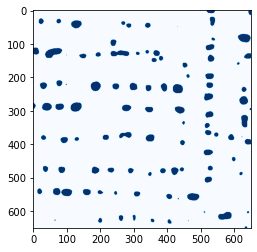

In [34]:
import matplotlib.pyplot as plt
plt.imshow(test_im>0, cmap='Blues')

In [38]:
# data preprocessing
def input_fn(request_body, request_content_type):
    assert request_content_type == "application/json"
    config_inf_aug = {'augmentations': {'Normalize': {'mean': [0.0, 0.0, 0.0, 0.0],
                                                      'std': [1.0, 1.0, 1.0, 20.0],
                                                      'max_pixel_value': 255,
                                                      'p': 1.0}},'p': 1.0}
    inf_tiler = InferenceTiler(
            'torch',
            width=512,
            height=512,
            x_step=None,
            y_step=None,
            augmentations=transform.process_aug_dict(
                config_inf_aug)
            )
    im_path = json.loads(request_body)["inputs"]
    inf_input, idx_refs, (src_im_height, src_im_width) = inf_tiler(im_path)
    inf_input = torch.from_numpy(inf_input).float().to(device)
    return inf_input, idx_refs, (src_im_height, src_im_width)

In [43]:
dummy_data = {'inputs': './data/trees/RGB+ELEV/SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img1105.tif'}
# input_fn(dummy_data, "application/json")
s1 = json.dumps(dummy_data)
input_fn(s1, "application/json")

'{"inputs": "./data/trees/RGB+ELEV/SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img1105.tif"}'

In [36]:
# inference
def predict_fn(input_object, model):
    with torch.no_grad():
        model.eval()
    subarr_preds_list = []
    batch_size=20
    for batch_i in range(0, inf_input.shape[0], batch_size):
        if batch_i + batch_size <= inf_input.shape[0]:
            subarr_pred = model(inf_input[
                batch_i:batch_i+batch_size, ...
            ])
        else:
            subarr_pred = model(inf_input[
                batch_i:, ...
            ])
        subarr_preds_list.append(subarr_pred.cpu().data.numpy())
    subarr_preds = np.concatenate(subarr_preds_list, axis=0)
    return subarr_preds

In [37]:
# postprocess
output_file_name = './test.tif'
def output_fn(subarr_preds, output_file_name):
    stitching_method = 'average'
    stitched_result = image.stitch_images(subarr_preds,
                                    idx_refs=idx_refs,
                                    out_width=src_im_width,
                                    out_height=src_im_height,
                                    method=stitching_method)
    skimage.io.imsave(output_file_name,stitched_result, check_contrast=False)
    return 